In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import Voronoi, voronoi_plot_2d

from IPython.display import clear_output

In [27]:
# Preproceso de datos

df = pd.read_csv('datablow.csv');
# Quitamos la columna que no nos sirve
df = df.drop(columns=['Unnamed: 0'])
df.columns = ['feature 1', 'feature 2']
df['Cluster'] = 0
df.head()

,feature 1,feature 2,Cluster
0,0.599449,0.143441,0
1,0.699177,0.107459,0
2,0.560343,0.185676,0
3,0.562573,0.089642,0
4,0.084258,0.832261,0


In [28]:
def get_random_centroids_df(df, k):
    return (df.sample(n=k, replace=False)).drop(columns=['Cluster'])

In [29]:
def assign_cluster_df(df, k, centroids_df, norm=np.linalg.norm):
    df_cluster = df.copy()
    centroids_np = centroids_df[['feature 1', 'feature 2']].to_numpy()

    # Para cada renglón del dataframe recibido comparamos
    # la distancia del punto a cada centroide y actualizamos su
    # cluster asignado en el dataframe
    
    for index, row in df_cluster[['feature 1', 'feature 2']].iterrows():
        point = np.array(row)
        min_dist = np.inf
        cluster_indx = -1

        for i in range(k):
            distance = norm(point - centroids_np[i])
            if distance < min_dist:
                min_dist = distance
                cluster_indx = i
        
        df_cluster.at[index, 'Cluster'] = cluster_indx
    return df_cluster


In [30]:
def get_mean_centroids_df(cluster_df):
    # Agrupamos las entradas en el dataframe por cluster asignado
    # calculamos el punto medio para cada cluster coordenada a coordenada y
    # regresamos.
    out = cluster_df.groupby(['Cluster']).mean()
    return out

In [31]:
def compute_frobenius_norm(old_centroids_df, new_centroids_df):
    return np.linalg.norm(
        old_centroids_df.to_numpy() - 
        new_centroids_df.to_numpy()
    )

In [32]:
def KMeans_has_converged(old_centroids, new_centroids):
    # Si los centroides no han cambiado es porque el algoritmo ha convergido.
    return old_centroids.equals(new_centroids)

In [33]:
# código obtenido de https://www.youtube.com/watch?v=lX-3nGHDhQg y adaptado
def plot_clusters(clusters, labels, centroids, iteration, frob_norm, centroid_colors):
    data_2d = clusters[['feature 1', 'feature 2']].to_numpy()
    centroids_2d = centroids.to_numpy()
    #clear_output(wait=True)
    plt.suptitle(f'Iteración: {iteration}')
    plt.title(f'Norma Frobenius: {frob_norm}')
    
    plt.scatter(x=data_2d[:,0], y=data_2d[:,1], c=labels)
    plt.scatter(x=centroids_2d[:,0], y=centroids_2d[:,1], c=centroid_colors, marker='x', s=100)

    plt.show()

In [34]:
def plot_voronoi(clusters, labels, centroids, iteration, frob_norm, centroid_colors):

    data_2d = clusters[['feature 1', 'feature 2']].to_numpy()
    centroids_2d = centroids.to_numpy()
    #clear_output(wait=True)
    vor = Voronoi(centroids_2d)
    voronoi_plot = voronoi_plot_2d(vor)
    plt.suptitle(f'Iteración: {iteration}')
    plt.title(f'Norma Frobenius: {frob_norm}')
    
    plt.scatter(x=data_2d[:,0], y=data_2d[:,1], c=labels)
    plt.scatter(x=centroids_2d[:,0], y=centroids_2d[:,1], c=centroid_colors, marker='x', s=100)

    plt.show()


In [62]:
def KMeans(data, k, norm, scatter_plot=False, voronoi_plot=False, frobenius_plot_evolution=False, frobenius_plot=False):
    frobenius_norms = []

    # Obtener k centroides de forma aleatoria
    centroids = get_random_centroids_df(data, k)

    old_centroids = pd.DataFrame()

    iteration = 1

    while not KMeans_has_converged(old_centroids, centroids):

        old_centroids = centroids
        
        # Reasignar a cada punto su cluster
        cluster_df = assign_cluster_df(data, k, centroids, norm)

        # Obtener nuevos centroides con la media
        centroids = get_mean_centroids_df(cluster_df)

        current_frobenius_norm = compute_frobenius_norm(old_centroids, centroids)
        frobenius_norms.append(current_frobenius_norm)
        
        if not frobenius_plot:
            clear_output(wait=True)

        if scatter_plot:
            plot_clusters(
                cluster_df, 
                cluster_df['Cluster'].map({i : f'C{i}' for i in range(k)}), 
                centroids, 
                iteration,
                current_frobenius_norm,
                [i+1 for i in range(k)]
            )
        if voronoi_plot:
            plot_voronoi(
                cluster_df, 
                cluster_df['Cluster'].map({i : f'C{i}' for i in range(k)}), 
                centroids, 
                iteration,
                current_frobenius_norm,
                [i+1 for i in range(k)]
            )
        if frobenius_plot_evolution:
            plt.plot(range(1, iteration+1), frobenius_norms)
            plt.title('Comportamiento de tolerancia relativa')
            plt.xlabel('Iteración')
            plt.ylabel('Norma de Frobenius')
            plt.show()

        iteration += 1

    if frobenius_plot:
        plt.plot(range(1, iteration), frobenius_norms)
        plt.suptitle(f'Comportamiento de tolerancia relativa para k = {k}')
        plt.title(f'Iteraciones realizadas: {iteration}')
        plt.xlabel('Iteración')
        plt.ylabel('Norma de Frobenius')
        plt.show()

    return (centroids, cluster_df)

In [36]:
def wcss(centroids, clusters, k, norm=np.linalg.norm):
    # Traducción literal de la fórmula para calcular WCSS
    sum1 = 0
    # Para cada cluster sumamos
    for i in range(k):
        sum2 = 0
        cluster_centroid = centroids.iloc[i].to_numpy()

        # Para cada punto en el cluster que estamos considerando sumamos
        # el error cuadrático de las distancias
        for index, point in clusters.loc[clusters['Cluster'] == i].iterrows():
            sum2 += np.square(norm(point[:2].to_numpy()-cluster_centroid))
        sum1 += sum2

    return sum1

In [37]:
def plot_wcss(data, min, max, norm=np.linalg.norm):
    wcss_data = (max+1-min)*[0]

    for k in range(min, max+1):
        centroids, clusters = KMeans(data, k, norm)
        wcss_data[k-min]=(wcss(centroids, clusters, k, norm))

        clear_output(wait=True)
        plt.plot(range(min, max+1), wcss_data)
        plt.title('Método del codo')
        plt.xlabel('Número de clusters')
        plt.ylabel('WCSS')
        plt.show()


# Ejercicio 1

Usando K-Means y el dataset datablow.csv

### (a) Para $k = 2, \dots, 16$ calcula el WCSS y grafica los WCSS de cada $K$ en una gráfica de lineas.

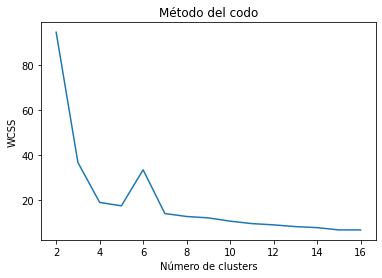

In [38]:
min = 2
max = 16

plot_wcss(df, min, max)

### (b) Usando la gráfica anterior justifica qué valor de $k$ sería "óptimo" según el criterio del "codo" y grafica su daigrama de Voronoi generado por los centroides del cluster generado para dicho $k$.

En virtud de que la gráfica sufre un cambio brusco en pendiente para k=4, se concluye por el método del codo que k=4 es óptimo.

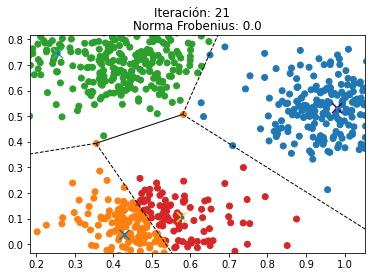

In [65]:
KMeans(df, 4, np.linalg.norm, voronoi_plot=True);

### (c) Grafica el comportamiento de la tolerancia relativa, es decir, la norma de Frobenius de la diferencia de los centrtoides como matriz para cada iteración.

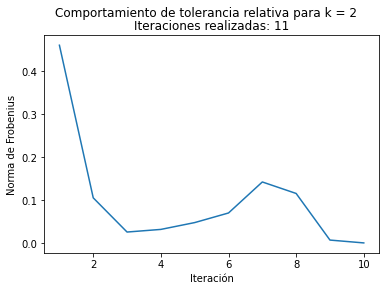

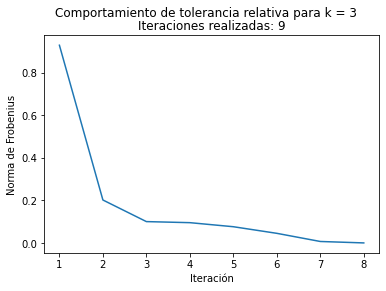

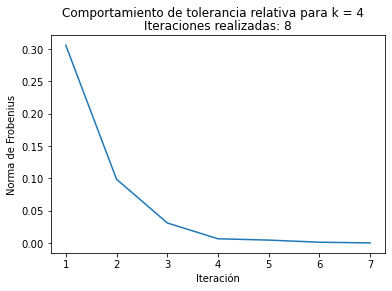

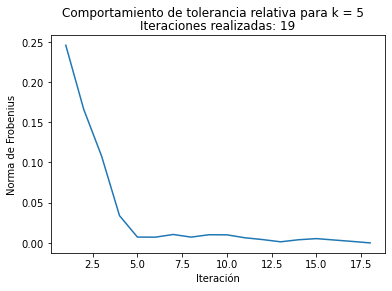

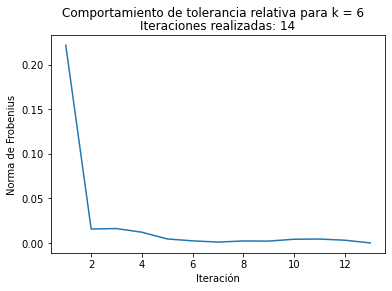

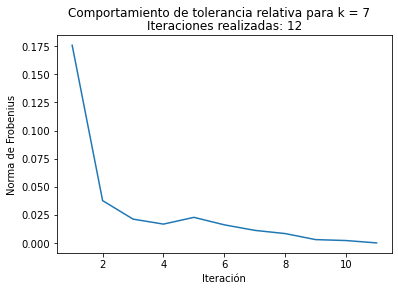

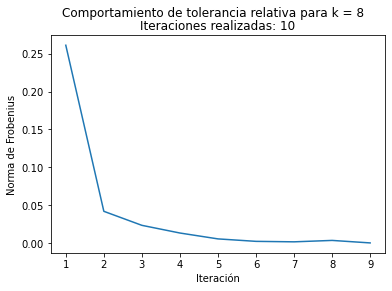

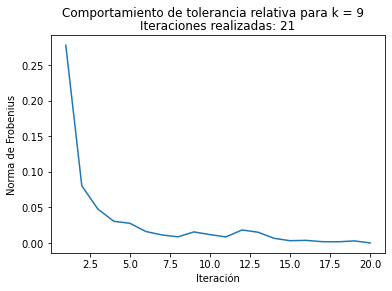

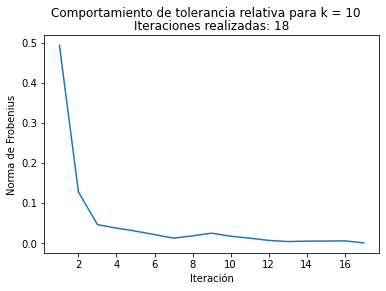

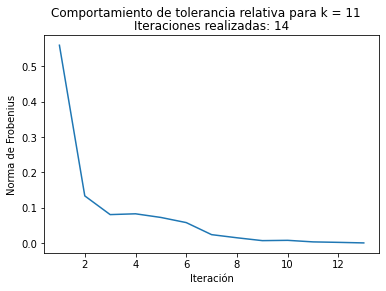

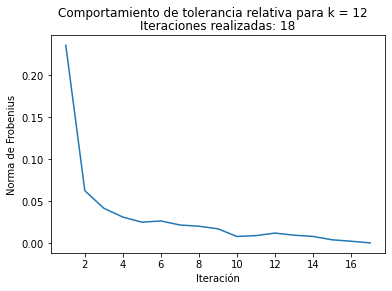

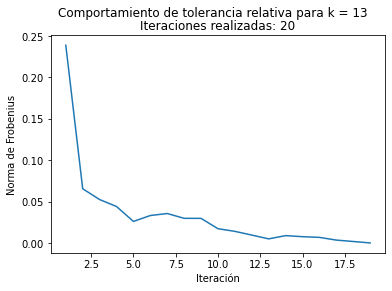

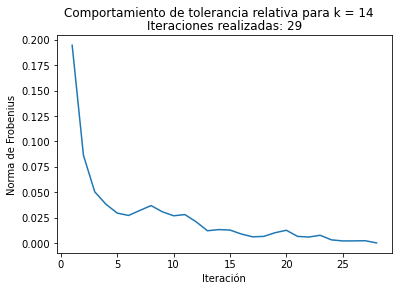

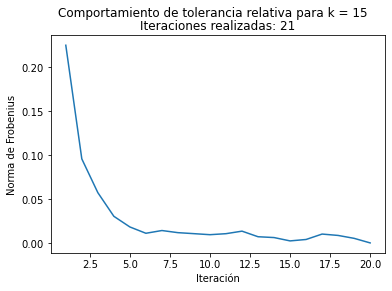

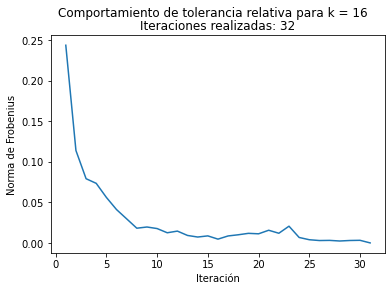

In [66]:
for k in range(2, 17):
    KMeans(df, k, np.linalg.norm, frobenius_plot=True)